In [1]:
import epmwebapi as epm
import datetime as dt
import numpy as np
import pandas as pd
import math

#### Para não expor o usuário e senha do EPM, as informações são salvas numa variável de ambiente e busco via código

In [2]:
import os
credentials = os.environ.get('user_and_password').split(';')
user = credentials[0]
password = credentials[1]

#### cria conexao com EPM Server

In [3]:
epmConn = epm.EpmConnection('http://localhost:44333', 'http://localhost:44332', user, password)

#### configura data inicial e final do período a ser consultado os dados

In [4]:
iniTime = dt.datetime(2016, 1, 1, 0, 0, 0, 0)
endTime = iniTime + dt.timedelta(days=3)

#### Leitura de dados brutos(Raw) da tag R80711_Wind_direction que contém as medidas de direção do vento

Para entender como os valores de leitura são relacionados a direção do vento, veja essa <a href='http://snowfence.cfans.umn.edu/Components/winddirectionanddegreeswithouttable3.htm'>tabela</a>.

In [5]:
path = 'R80711_Wind_direction'
bv = epmConn.getDataObjects(path)

#cria objeto queryperiod
queryPeriod = epm.QueryPeriod(iniTime, endTime)

#aplica o objeto um historyReadRaw com o queryPeriod na basicVariable selecionada
result_direction = bv[path].historyReadRaw(queryPeriod)

#quantidade de dados buscandos
print(len(result_direction))

#fechando a conexão
connection.close()

432


#### Leitura de dados brutos(Raw) da tag R80711_Wind_speed que contém as medidas de velocidade do vento

In [6]:
path = 'R80711_Wind_speed'
bv = epmConn.getDataObjects(path)

#cria objeto queryperiod
queryPeriod = epm.QueryPeriod(iniTime, endTime)

#aplica o objeto um historyReadRaw com o queryPeriod na basicVariable selecionada
result_speed = bv[path].historyReadRaw(queryPeriod)

#quantidade de dados buscandos
print(len(result_speed))

432


#### Leitura de dados brutos(Raw) da tag R80711_Active_power quem contém as medidas de potência ativa

In [8]:
path = 'R80711_Active_power'
bv = epmConn.getDataObjects(path)

#cria objeto queryperiod
queryPeriod = epm.QueryPeriod(iniTime, endTime)

#aplica o objeto um historyReadRaw com o queryPeriod na basicVariable selecionada
result_power = bv[path].historyReadRaw(queryPeriod)

#quantidade de dados buscandos
print(len(result_power))

432


### Criação do dataframe pandas
corrige o problema: ValueError: Big-endian buffer not supported on little-endian compiler
para ser possível transformar os dados vindos do EPM em um Dataframe Pandas

In [9]:
#Direction
new_Quality = result_direction[:]['Quality'].byteswap().newbyteorder()
new_Timestamp = result_direction[:]['Timestamp']
new_Value = result_direction[:]['Value'].byteswap().newbyteorder()

d = {'Value':new_Value, 'Timestamp':new_Timestamp, 'Quality':new_Quality}
df_direction = pd.DataFrame(d)

#Speed
new_Quality = result_speed[:]['Quality'].byteswap().newbyteorder()
new_Timestamp = result_speed[:]['Timestamp']
new_Value = result_speed[:]['Value'].byteswap().newbyteorder()

d = {'Value':new_Value, 'Timestamp':new_Timestamp, 'Quality':new_Quality}
df_speed = pd.DataFrame(d)

#Active Power
new_Quality = result_power[:]['Quality'].byteswap().newbyteorder()
new_Timestamp = result_power[:]['Timestamp']
new_Value = result_power[:]['Value'].byteswap().newbyteorder()

d = {'Value':new_Value, 'Timestamp':new_Timestamp, 'Quality':new_Quality}
df_power = pd.DataFrame(d)

Mostra o formato dos dados, para esse caso são 432 linhas por 3 colunas

In [10]:
df_direction.shape

(432, 3)

# Análise dos Dados

#### Com a função describe() do Pandas podemos facilmente extrair algumas informações dos dados, como:
* Quantidade de dados
* Valor Máximo e Mínimo
* Média e Desvio Padrão
* Frequencia e Distribuição dos dados


In [11]:
df_direction.describe(include='all')

,Value,Timestamp,Quality
count,432.000000,432,432.0
unique,NaN,432,NaN
top,NaN,2016-01-01 20:40:00+00:00,NaN
freq,NaN,1,NaN
mean,178.895340,NaN,0.0
std,40.034126,NaN,0.0
min,70.830002,NaN,0.0
25%,161.342503,NaN,0.0
50%,194.260002,NaN,0.0
75%,210.359997,NaN,0.0


#### Removendo linhas que contenham algum valor NaN(nulo)

Para esse exemplo nenhuma linha foi removida porque o conjunto de dados não possuia valores NaN

In [12]:
df_direction_01 = df_direction.dropna(how='any')

df_direction_01.shape

(432, 3)

## Visualização

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
#Configuração da Paleta de cores e estilo
sns.set(palette="tab10_r", color_codes=True)
current_palette_7 = sns.color_palette("GnBu_d",2)
sns.set_palette(current_palette_7)

Histrograma mostrando a distribuição dos dados. 
<br/>Nele é possivel notar que existe uma grande quantidade de dados com valores entre 200 e 230 que representam a direção do vento Sudoeste

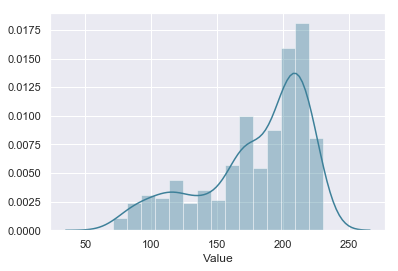

In [21]:
#geração do gráfico
ax=sns.distplot(df_direction_01['Value'], kde=True, bins=15)
fig = ax.get_figure()

Adicionando os dados de velocidade do vento, geramos um gráfico polar que mostra a dispersão da Direção e Velocidade.<br/> Com essa visualização confirmamos o que o histograma indicou(maior distribuição de ventos Sudoeste) e ainda apresenta a velocidade do vento em cada direção(quanto mais afastado do centro, maior a velocidade)

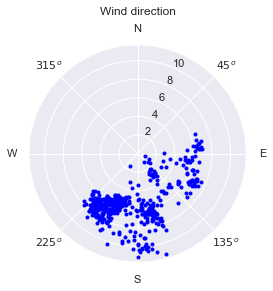

In [16]:
speed, direction = df_speed.Value, list(map(math.radians, df_direction.Value.tolist())),

ax1 = plt.subplot(111, polar=True)
ax1.set_theta_zero_location('N')
ax1.set_theta_direction(-1)
ax1.grid(True)
ax1.xaxis.set_ticklabels(['N',r"$45^{o}$",'E',r"$135^{o}$",'S',r"$225^{o}$",'W', r"$315^{o}$"])
ax1.set_title("Wind direction\n", va='bottom')
ax1.plot(direction, speed, 'b.')
plt.show()

Por fim adicionamos os dados de Potência Ativa ao gráfico, e com isso visualizamos em quais direções houve a maior geração de energia(quanto maior o circulo, maior a geração).

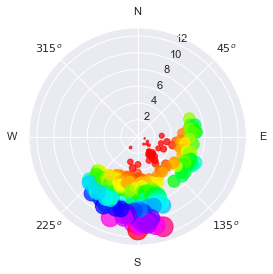

In [18]:
power = df_power.Value
colors = power/1000.
area = np.pi * speed**2

ax1 = plt.subplot(111, polar=True)
ax1.set_theta_zero_location('N')
ax1.set_theta_direction(-1)
ax1.xaxis.set_ticklabels(['N',r"$45^{o}$",'E',r"$135^{o}$",'S',r"$225^{o}$",'W', r"$315^{o}$"])

c = plt.scatter(direction, speed, c=colors, s=area, cmap=plt.cm.hsv)
c.set_alpha(0.75)
plt.show()

fig = ax1.get_figure()